In [81]:
import os
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss, coint, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import matplotlib

In [60]:
FIRST_SLICE_DATE: datetime = datetime.strptime('28/10/2018', '%d/%m/%Y')
SECOND_SLICE_DATE: datetime = datetime.strptime('1/5/2020', '%d/%m/%Y')

In [4]:
def filter_series(df: pd.DataFrame, date_key: str, slice1: datetime, slice2: datetime) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, date_key] = pd.to_datetime(dff.loc[:, date_key], unit='s')

    dff.loc[:, :] = dff[dff[date_key] >= slice1]
    dff.loc[:, :] = dff[dff[date_key] <= slice2]
    
    dff = dff.set_index(date_key)

    return dff.dropna()

In [5]:
def print_adf(df: pd.DataFrame, values_key: str) -> None:
    series = df.loc[:, values_key].values

    adf_test = adfuller(series, autolag='AIC')
    p_value = adf_test[1]

    dfResults = pd.Series(adf_test[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    #Add Critical Values
    for key,value in adf_test[4].items():
        dfResults[f'Critical Value ({key})'] = value

    print('Augmented Dickey-Fuller Test Results:')
    print(dfResults)

In [6]:
def print_kpss(df: pd.DataFrame, values_key: str) -> None:
    series = df.loc[:, values_key].values

    statistic, p_value, n_lags, critical_values = kpss(series, nlags="auto", regression='c')
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')

    for key, value in critical_values.items():
        print(f'   {key} : {value}')

# GAS series

Loading and cleaning gas data.

In [61]:
gas: pd.DataFrame = pd.read_csv(os.path.join('data', 'avg_gas_price.csv'), header=0)
gas.rename(columns={'UnixTimeStamp': 'date', 'Value (Wei)': 'values'}, inplace = True)
gas = gas[['date', 'values']].dropna()

## Original series

Let's see how the series looks like.

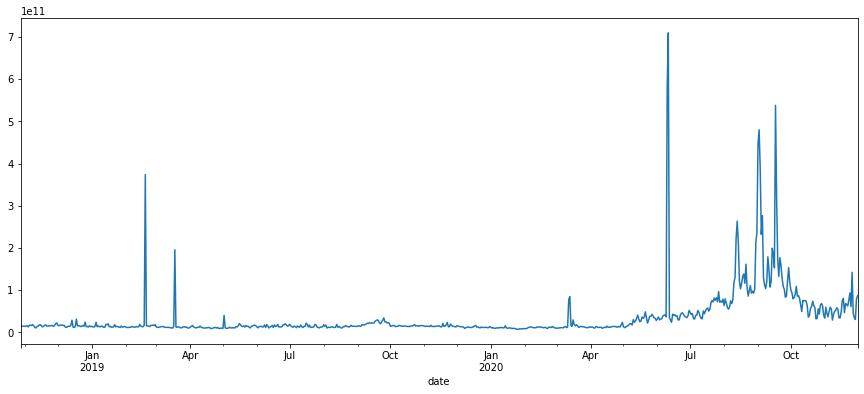

In [62]:
gas_plot = filter_series(df=gas, date_key='date', slice1=FIRST_SLICE_DATE, slice2=datetime.today())
gas_plot['values'].plot(figsize = (15, 6))
plt.show()

## Splitting the series

We can see there is two-stage in the series. The first stage ends around May first of 2020, from then the series changed. So let's split the series into two slices. 

In [63]:
gas_slice1 = filter_series(df=gas, date_key='date', slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
gas_slice2 = filter_series(df=gas, date_key='date', slice1=SECOND_SLICE_DATE, slice2=datetime.now())

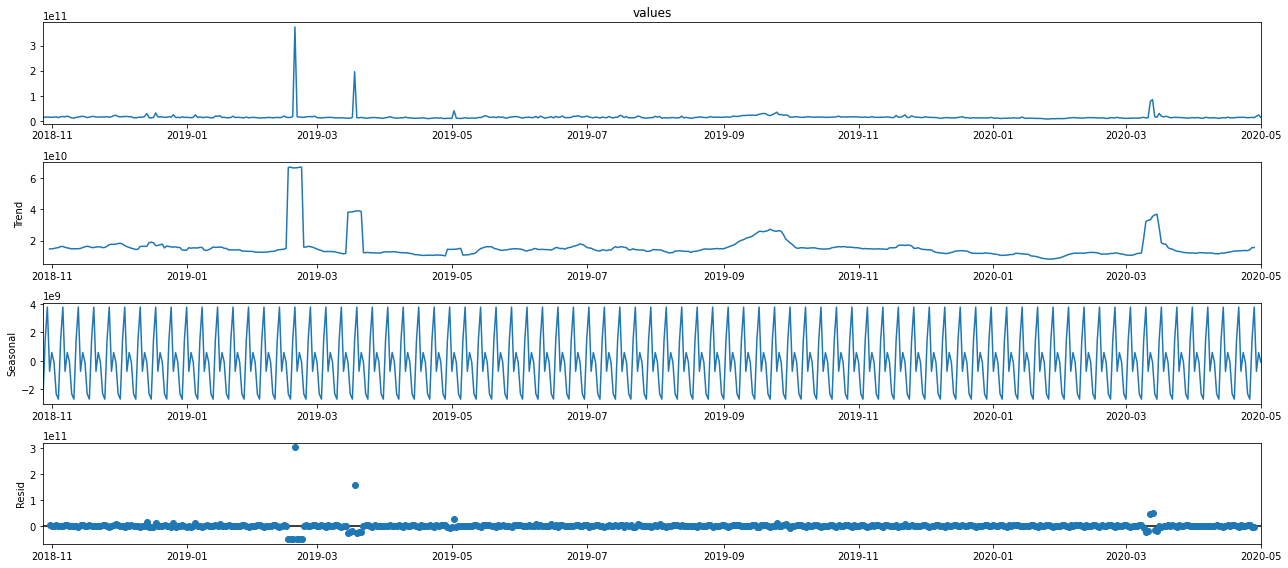

In [64]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=gas_slice1['values'], model='additive')
fig = decomposition.plot()
plt.show()

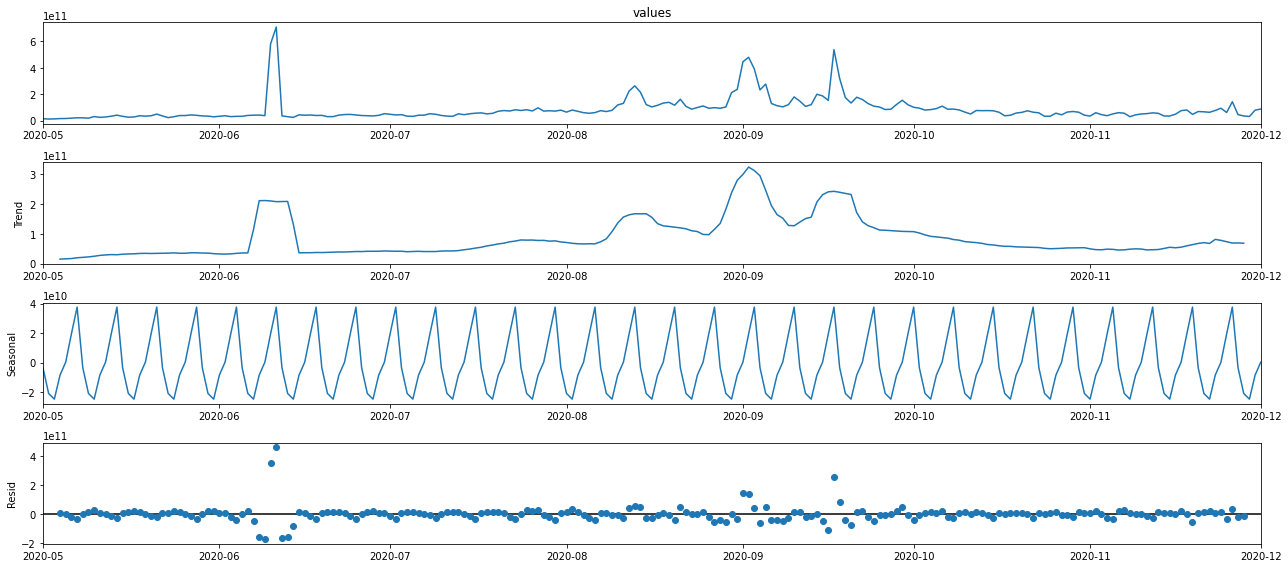

In [65]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=gas_slice2['values'], model='additive')
fig = decomposition.plot()
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [66]:
print_adf(df=gas_slice1, values_key='values')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -22.172498
P-Value                   0.000000
# Lags Used               0.000000
# Observations Used     551.000000
Critical Value (1%)      -3.442274
Critical Value (5%)      -2.866800
Critical Value (10%)     -2.569571
dtype: float64


In [67]:
print_adf(df=gas_slice2, values_key='values')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.968277
P-Value                   0.000026
# Lags Used               2.000000
# Observations Used     212.000000
Critical Value (1%)      -3.461578
Critical Value (5%)      -2.875272
Critical Value (10%)     -2.574089
dtype: float64


In both cases, we can reject the null hypothesis with all the confidence intervals. So, both series haven't a unit root. Hence, they are stationary series.

To confirm that, we are going to perform the kpss test for cross-validation.

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [68]:
print_kpss(df=gas_slice1, values_key='values')

KPSS Statistic: 0.2770300806916172
p-value: 0.1
num lags: 4
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [69]:
print_kpss(df=gas_slice2, values_key='values')

KPSS Statistic: 0.4047580073815829
p-value: 0.07510430716311081
num lags: 8
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


In both cases, p-values are greater than 0.05, and "KPSS Statistic" values are less than the critical values. So, we fail to reject H0, and because of that, we confirm that both series are stationary.

# Aragon activity series

Let's check what about the activity series.

In [37]:
aragon: pd.DataFrame = pd.read_csv(os.path.join('data', 'aragon_activity.csv'), header=0)

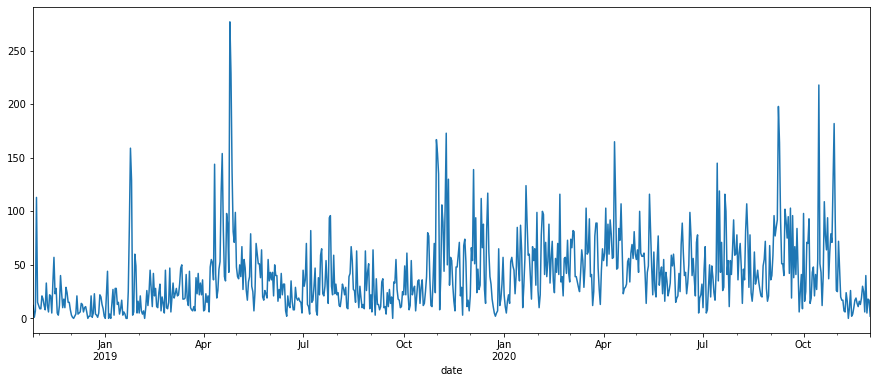

In [38]:
aragon_plot = filter_series(df=aragon, date_key='date', slice1=FIRST_SLICE_DATE, slice2=datetime.today())
aragon_plot['actions'].plot(figsize = (15, 6))
plt.show()

## Spliting the series

As we previously do with the gas series, let's split the series.

In [39]:
aragon_slice1 = filter_series(df=aragon, date_key='date', slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
aragon_slice2 = filter_series(df=aragon, date_key='date', slice1=SECOND_SLICE_DATE, slice2=datetime.now())

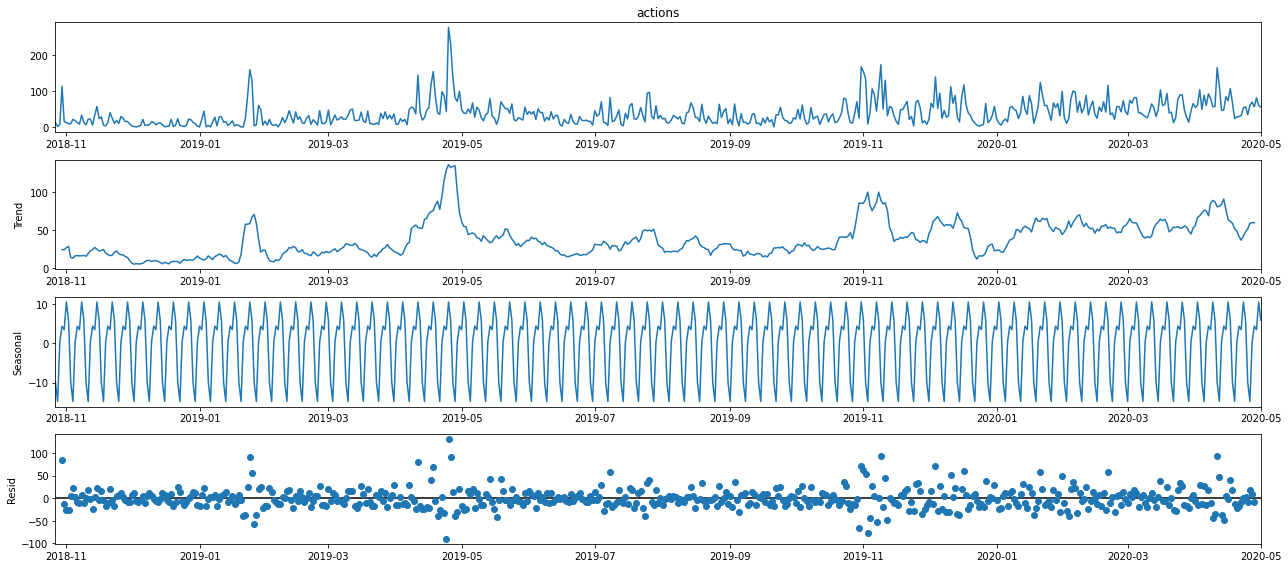

In [40]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=aragon_slice1['actions'], model='additive')
fig = decomposition.plot()
plt.show()

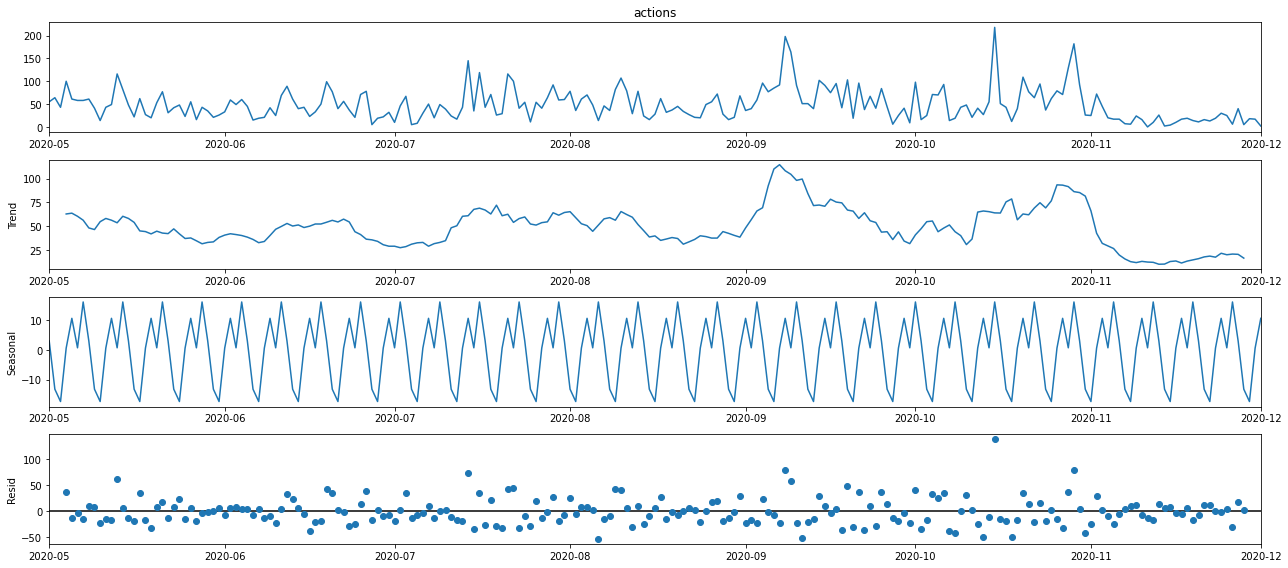

In [41]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=aragon_slice2['actions'], model='additive')
fig = decomposition.plot()
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [42]:
print_adf(df=aragon_slice1, values_key='actions')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.004175
P-Value                   0.001389
# Lags Used               7.000000
# Observations Used     545.000000
Critical Value (1%)      -3.442406
Critical Value (5%)      -2.866858
Critical Value (10%)     -2.569602
dtype: float64


In [43]:
print_adf(df=aragon_slice2, values_key='actions')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.226281
P-Value                   0.018513
# Lags Used              15.000000
# Observations Used     199.000000
Critical Value (1%)      -3.463645
Critical Value (5%)      -2.876176
Critical Value (10%)     -2.574572
dtype: float64


In the first series, either p-value or statistic value are lower than all the confidence and critical values. In the second case, its p-value is slower than the 0.05 confidence interval. Those results suggest that we can reject H0 in favor of H1, in other words, both series are stationary.

## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [44]:
print_kpss(df=aragon_slice1, values_key='actions')

KPSS Statistic: 1.336036192524901
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [45]:
print_kpss(df=aragon_slice2, values_key='actions')

KPSS Statistic: 0.20411031920089395
p-value: 0.1
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


aragon_slice2 has values that suggest that we fail to reject H0. So, it is definitely a stationary series.

However, in the case of aragon_slice1 we can reject H0 in favor of H1, meaning that it isn't a stationary series.
When the ADF test says that the series is stationary, and the KPSS says that it isn't, then we have a difference stationary series, which we can convert in a stric stationary series.

## Converting aragon_slice1 into a strict stationary series

In [51]:
aragon_slice1['actions_diff'] = aragon_slice1['actions'] - aragon_slice1['actions'].shift(1)
aragon_slice1 = aragon_slice1.dropna()

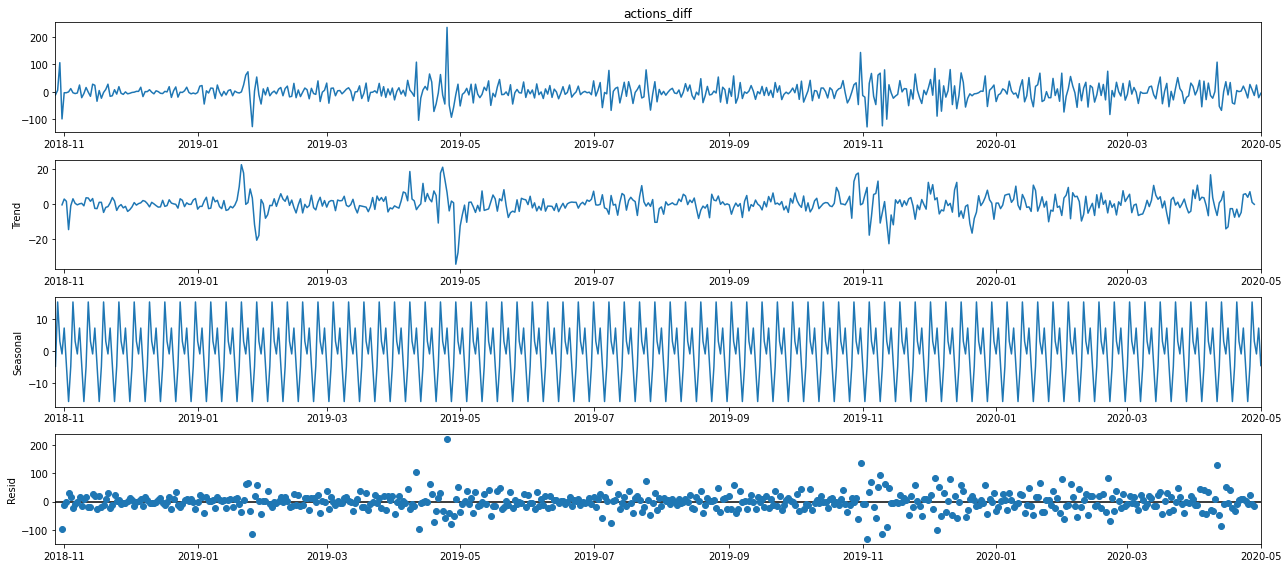

In [52]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x=aragon_slice1['actions_diff'], model='additive')
fig = decomposition.plot()
plt.show()

In [53]:
print_adf(df=aragon_slice1, values_key='actions_diff')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -9.938855e+00
P-Value                 2.697822e-17
# Lags Used             1.200000e+01
# Observations Used     5.390000e+02
Critical Value (1%)    -3.442541e+00
Critical Value (5%)    -2.866917e+00
Critical Value (10%)   -2.569634e+00
dtype: float64


In [54]:
print_kpss(df=aragon_slice1, values_key='actions_diff')

KPSS Statistic: 0.058766160056329224
p-value: 0.1
num lags: 63
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Now, either ADF or KPSS states that the series is stationary.

# Cointegration Test

From the above test, we conclude that both series have an integration order of 1, I(1). To check if they are cointegrated, we will use the augmented Engle-Granger two-step cointegration test.

Where:

    * H0 = there is no cointegration.
    * H1 = there is cointegrating relationship.

In [78]:
def print_coint(df1: pd.DataFrame, df2: pd.DataFrame, k1: str, k2: str) -> None:
    t_statistic, p_value, critical_values = coint(df1[k1], df2[k2])
    
    print('Cointegration statistics:\n')
    print(f'T-Statistic = {t_statistic}')
    print(f'P-value = {p_value}')
    print('Critical values:')
    
    keys: list = ['1%', '5%', '10%']
    for i, value in enumerate(critical_values):
        print(f'   {keys[i]} : {value}')

In [79]:
print_coint(df1=gas_slice1, df2=aragon_slice1, k1='values', k2='actions_diff')

Cointegration statistics:

T-Statistic = -22.204503576358988
P-value = 0.0
Critical values:
   1% : -3.9164268376586375
   5% : -3.347241584283319
   10% : -3.0521562368042265


In [80]:
print_coint(df1=gas_slice2, df2=aragon_slice2, k1='values', k2='actions')

Cointegration statistics:

T-Statistic = -5.075315041319186
P-value = 0.00011940780969935985
Critical values:
   1% : -3.948349197309809
   5% : -3.3648308559699536
   10% : -3.0643280854223076


The p-values < 0.05. Thus rejecting the null hypothesis. Thus they are cointegrated.

If two or more time-series are cointegrated, then there must be Granger causality between them - either one-way or in both directions. However, the converse is not true.

# Granger Causality Tests

Where:

    * H0: The second column, x2, does NOT Granger cause the time series in the first column, x1
    * H1: x2 Granger cause x1

In [117]:
def grangers_causation_matrix(data, variables, maxlag, test = 'ssr_chi2test'):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
            
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]

    return df

In [130]:
slice1: pd.DataFrame = pd.DataFrame(
    {'aragon_actions': aragon_slice1['actions_diff'].tolist(),
     'gasPrice': gas_slice1['values'].tolist(),
    })
    
gc_res1 = grangercausalitytests(slice1, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4479  , p=0.5036  , df_denom=548, df_num=1
ssr based chi2 test:   chi2=0.4503  , p=0.5022  , df=1
likelihood ratio test: chi2=0.4502  , p=0.5023  , df=1
parameter F test:         F=0.4479  , p=0.5036  , df_denom=548, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8381  , p=0.4331  , df_denom=545, df_num=2
ssr based chi2 test:   chi2=1.6917  , p=0.4292  , df=2
likelihood ratio test: chi2=1.6891  , p=0.4298  , df=2
parameter F test:         F=0.8381  , p=0.4331  , df_denom=545, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6030  , p=0.6133  , df_denom=542, df_num=3
ssr based chi2 test:   chi2=1.8324  , p=0.6079  , df=3
likelihood ratio test: chi2=1.8293  , p=0.6086  , df=3
parameter F test:         F=0.6030  , p=0.6133  , df_denom=542, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4725  , p=0.7560  

In [128]:
slice2: pd.DataFrame = pd.DataFrame(
    {'aragon_actions': aragon_slice2['actions'].tolist(),
     'gasPrice': gas_slice2['values'].tolist(),
    })
    
gc_res2 = grangercausalitytests(slice2, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4850  , p=0.0633  , df_denom=211, df_num=1
ssr based chi2 test:   chi2=3.5345  , p=0.0601  , df=1
likelihood ratio test: chi2=3.5056  , p=0.0612  , df=1
parameter F test:         F=3.4850  , p=0.0633  , df_denom=211, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8184  , p=0.1649  , df_denom=208, df_num=2
ssr based chi2 test:   chi2=3.7243  , p=0.1553  , df=2
likelihood ratio test: chi2=3.6921  , p=0.1579  , df=2
parameter F test:         F=1.8184  , p=0.1649  , df_denom=208, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1709  , p=0.3219  , df_denom=205, df_num=3
ssr based chi2 test:   chi2=3.6327  , p=0.3040  , df=3
likelihood ratio test: chi2=3.6020  , p=0.3078  , df=3
parameter F test:         F=1.1709  , p=0.3219  , df_denom=205, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3255  , p=0.2617  